In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py
import lmfit
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [9]:
def autocorrelation_vec(x, minLag=0, maxLag=100, dt=1, dtau=1, normalize=True):
    r"""
    Compute the autocorrelation of a time dependent vector.

    $$ \langle \vec v(t) \cdot \vec v(t + \tau) \rangle $$

    Parameters
    ----------
    x : numpy.ndarray[N,d]
        The vector to compute the MSD for.

    minLag : float
        The minimum lag to compute, in the same units as `dt`.

    maxLag : float
        The maximum lag to compute, in the same units as `dt`.

    dt : float
        The time difference between each point in `x`.

    dtau : float
        The interval at which to sample the autocorrelation, in the same
        units as `dt`.

    normalize : bool
        Whether to normalize the autocorrelation values by the first
        entry.

    Returns
    -------
    lagArr : numpy.ndarray[M]
        The time lags for which the autocorrelation is computed.

    autocorr : numpy.ndarray[M]
        The autocorrelation at each time lag.

    """

    # These are indices
    lagArr = np.arange(minLag / dt, maxLag / dt, dtau / dt).astype(np.int64)
    lagArr = np.unique(lagArr)

    # Make sure we don't try to compute lags longer than the length of
    # the vector
#    lagArr = lagArr[lagArr < len(x)]

    autocorrArr = np.zeros(len(lagArr))

    for i in range(len(lagArr[lagArr < len(x)])):
        autocorrArr[i] = np.mean([np.dot(velocityArr[lagArr[i]:][j], velocityArr[:len(velocityArr)-lagArr[i]][j]) for j in range(len(velocityArr) - lagArr[i])])

    if normalize:
        autocorrArr = autocorrArr / autocorrArr[0]

    return lagArr * dt, autocorrArr

def meanSquaredDisplacement(trajectory, minLag=1, maxLag=100, dt=1, dtau=1):
    """
    Compute the mean-squared displacement for a trajectory
    for a variety of lags.

    In other words, the autocorrelation of the squared displacement.

    Parameters
    ----------
    trajectory : numpy.ndarray[N,d]
        The trajectory to compute the MSD for.

    minLag : float
        The minimum lag to compute, in the same units as `dt`.

    maxLag : float
        The maximum lag to compute, in the same units as `dt`.

    dt : float
        The time difference between each point in `trajectory`.

    dtau : float
        The interval at which to sample the MSD, in the same
        units as `dt`.

    Returns
    -------
    lagArr : numpy.ndarray[M]
        The time lags for which the MSD is computed.

    msd : numpy.ndarray[M]
        The MSD at each time lag.
    """
    # These are indices
    lagArr = np.arange(minLag / dt, maxLag / dt, dtau / dt).astype(np.int64)

    msdArr = np.zeros(len(lagArr))

    for i in range(len(lagArr)):
        lag = lagArr[i]
        msdArr[i] = np.mean(np.sum((trajectory[lag:] - trajectory[:-lag])**2, axis=-1))

    return lagArr * dt, msdArr


In [3]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2025-09-20.h5'

minimumLength = 10 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 15 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|███████| 435/435 [01:06<00:00,  6.58it/s]

Loaded 339 segments!


In [10]:
maxLag = 30 # [s]
dtau = 0.5 # [s]
dt = 1/metadataArr[0]["fps"]

# Make sure we don't take trajectories with objects in the
# enclosure, since that could introduce extra effects.
objectsArr = [metadataArr[i]["objects"] == "[]" for i in range(len(dataArr))]
goodIndices = np.where(objectsArr)[0]

autocorrArr = np.zeros((len(goodIndices), int(maxLag // dtau)))
tArr = np.zeros((len(goodIndices), int(maxLag // dtau)))

for i in tqdm(range(len(goodIndices))): 
    trajectory = dataArr[goodIndices[i]]
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt

    tArr[i], autocorrArr[i] = autocorrelation_vec(velocityArr, maxLag=maxLag, dt=dt, dtau=dtau)

100%|█████████████████████████████████████████| 339/339 [00:33<00:00, 10.13it/s]


In [11]:
paramArr = np.zeros((len(goodIndices), 2))
DArr = []

for i in tqdm(range(len(goodIndices))):
    try:
        model = lmfit.models.ExponentialModel()
        params = model.guess(autocorrArr[i], tArr[i])
        fit = model.fit(autocorrArr[i], params, x=tArr[i])
        
        paramArr[i] = fit.params["amplitude"].value, fit.params["decay"].value

        DArr.append(1/paramArr[i,1])
    except:
        continue

100%|████████████████████████████████████████| 339/339 [00:01<00:00, 318.62it/s]


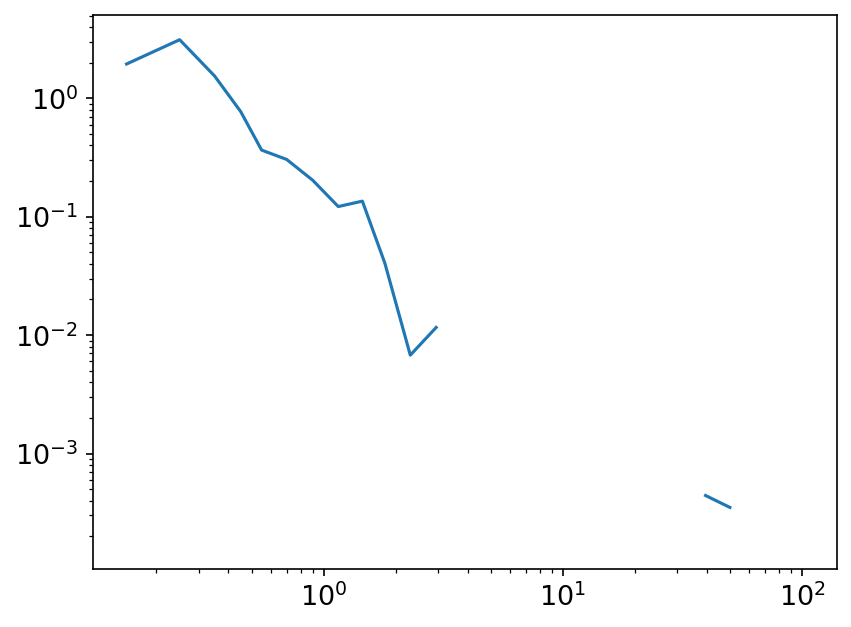

In [12]:
import powerlaw

powerlaw.plot_pdf(DArr / np.mean(DArr), xmin=1e-1)
plt.show()

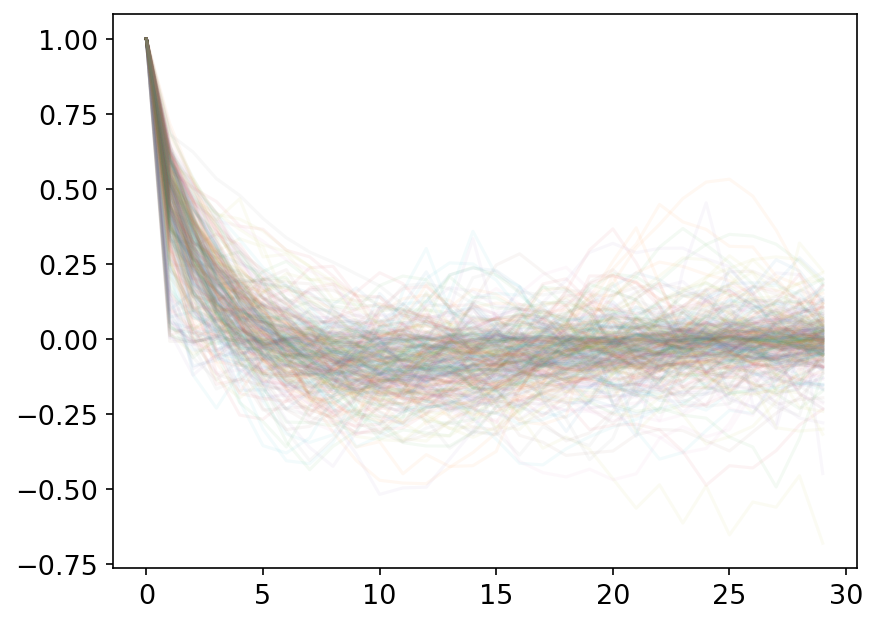

In [45]:
order = np.arange(len(goodIndices))
np.random.shuffle(order)
fps = metadataArr[0]["fps"]

for i in order:
    plt.plot(lagArr, autocorrArr[i], '-', alpha=0.05)

# mean = np.nanmean(msdArr, axis=0)

# plt.plot(lagArr/fps, np.sqrt(mean), c='black', label='Mean')

# plt.plot(lagArr/fps, 40*(lagArr/fps)**(1/2), '--', c='brown', label='Brownian', alpha=0.75)
# plt.plot(lagArr/fps, 30*(lagArr/fps)**1, '--', c='gray', label='Ballistic', alpha=0.75)

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Time [s]')
# plt.ylabel('$\\sqrt{\\langle r^2 \\rangle}$ [mm]')
# #plt.title(f'Mean Squared Displacement for Ant Motion\nUncropped')
# #plt.title(f'Mean Squared Displacement for Ant Motion\nCropped at walls (1cm)')
# plt.title(f'Mean Squared Displacement for Ant Motion\nOnly at walls (2 cm)')
# plt.legend()
# #pltsaveall('06_MSD_OnlyWalls')
plt.show()

In [76]:
maxLag = 60 # [s]
dtau = 0.5

# Make sure we don't take trajectories with objects in the
# enclosure, since that could introduce extra effects.
objectsArr = [metadataArr[i]["objects"] == "[]" for i in range(len(dataArr))]
goodIndices = np.where(objectsArr)[0]

msdArr = np.zeros((len(goodIndices), int(maxLag/dtau) - 2))

for i in tqdm(range(len(goodIndices))): 
    lagArr, msdArr[i] = meanSquaredDisplacement(dataArr[goodIndices[i]], maxLag=maxLag, dt=dt, dtau=dtau)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [00:12<00:00, 19.49it/s]


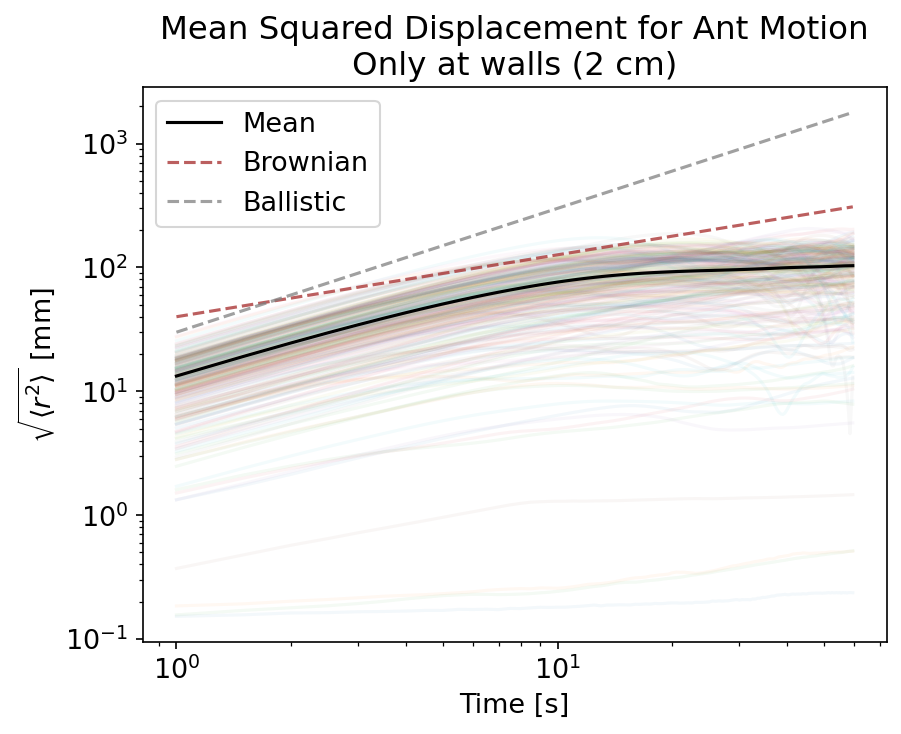

In [77]:
order = np.arange(len(goodIndices))
np.random.shuffle(order)
fps = metadataArr[0]["fps"]

for i in order:
    plt.plot(lagArr, np.sqrt(msdArr[i]), '-', alpha=0.05)

mean = np.nanmean(msdArr, axis=0)

plt.plot(lagArr, np.sqrt(mean), c='black', label='Mean')

plt.plot(lagArr, 40*(lagArr)**(1/2), '--', c='brown', label='Brownian', alpha=0.75)
plt.plot(lagArr, 30*(lagArr)**(1), '--', c='gray', label='Ballistic', alpha=0.75)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('$\\sqrt{\\langle r^2 \\rangle}$ [mm]')
#plt.title(f'Mean Squared Displacement for Ant Motion\nUncropped')
#plt.title(f'Mean Squared Displacement for Ant Motion\nCropped at walls (1cm)')
plt.legend()
plt.show()